In [5]:
from pathlib import Path

import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
from torchvision.models import resnet50

from ml_carbucks.utils.coco import create_dataset_custom

IMG_SIZE = 320
BATCH_SIZE = 1
NUM_CLASSES = 3
EPOCHS = 70

class CenterNetHead(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # Shared conv
        self.shared = nn.Sequential(
            nn.Conv2d(in_channels, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        # Separate heads
        self.heatmap = nn.Conv2d(256, num_classes, 1)
        self.wh = nn.Conv2d(256, 2, 1)
        self.offset = nn.Conv2d(256, 2, 1)
        self._init_weights()

    def _init_weights(self):
        # Heatmap bias init -> lower confidence initially
        self.heatmap.bias.data.fill_(-2.19)

    def forward(self, x):
        feat = self.shared(x)
        return {
            'heatmap': torch.sigmoid(self.heatmap(feat)),
            'wh': self.wh(feat),
            'offset': self.offset(feat),
        }


class CenterNet(nn.Module):
    def __init__(self, num_classes=3, backbone_name='resnet50', pretrained=True):
        super().__init__()
        backbone = resnet50(weights='IMAGENET1K_V1' if pretrained else None)
        self.backbone = nn.Sequential(*list(backbone.children())[:-2])  # C5 feature map
        self.head = CenterNetHead(2048, num_classes)

    def forward(self, x):
        feat = self.backbone(x)
        out = self.head(feat)
        return out

def focal_loss(pred, gt):
    pos_inds = gt.eq(1).float()
    neg_inds = gt.lt(1).float()
    neg_weights = torch.pow(1 - gt, 4)

    pred = torch.clamp(pred, 1e-6, 1 - 1e-6)
    pos_loss = torch.log(pred) * torch.pow(1 - pred, 2) * pos_inds
    neg_loss = torch.log(1 - pred) * torch.pow(pred, 2) * neg_weights * neg_inds

    num_pos = pos_inds.float().sum()
    pos_loss = pos_loss.sum()
    neg_loss = neg_loss.sum()

    return -(pos_loss + neg_loss) / (num_pos + 1e-4)

def compute_loss(preds, targets):
    hm_loss = focal_loss(preds['heatmap'], targets['heatmap'])
    wh_loss = F.l1_loss(preds['wh'], targets['wh'], reduction='mean')
    off_loss = F.l1_loss(preds['offset'], targets['offset'], reduction='mean')
    return hm_loss + wh_loss + off_loss, (hm_loss, wh_loss, off_loss)

def decode_predictions(preds, conf_thresh=0.5, stride=32, K=100, nms_kernel=3):
    """
    preds: dict with 'heatmap', 'wh', 'offset'
    conf_thresh: minimum confidence to keep a detection
    stride: scaling factor from heatmap to original image
    K: max number of detections per class
    nms_kernel: size of max pooling for NMS
    """
    heatmap, wh, offset = preds['heatmap'], preds['wh'], preds['offset']
    batch, cat, height, width = heatmap.size()

    # --- NMS on heatmap ---
    pooled = F.max_pool2d(heatmap, kernel_size=nms_kernel, stride=1, padding=nms_kernel//2)
    keep = (pooled == heatmap).float()
    heatmap = heatmap * keep

    boxes_list = []
    scores_list = []
    labels_list = []

    for b in range(batch):
        for c in range(cat):
            hm_flat = heatmap[b, c].view(-1)
            topk_scores, topk_inds = torch.topk(hm_flat, K)
            topk_mask = topk_scores > conf_thresh
            if topk_mask.sum() == 0:
                continue

            topk_scores = topk_scores[topk_mask]
            topk_inds = topk_inds[topk_mask]

            ys = (topk_inds // width).float()
            xs = (topk_inds % width).float()

            w = wh[b, 0].view(-1)[topk_inds]
            h = wh[b, 1].view(-1)[topk_inds]

            off_x = offset[b, 0].view(-1)[topk_inds]
            off_y = offset[b, 1].view(-1)[topk_inds]

            xs = xs + off_x
            ys = ys + off_y

            x1 = (xs - w / 2) * stride
            y1 = (ys - h / 2) * stride
            x2 = (xs + w / 2) * stride
            y2 = (ys + h / 2) * stride

            boxes = torch.stack([x1, y1, x2, y2], dim=-1)
            boxes_list.append(boxes)
            scores_list.append(topk_scores)
            labels_list.append(torch.full_like(topk_scores, c, dtype=torch.int))

    if len(boxes_list) == 0:
        return torch.empty((0, 4)), torch.empty((0,)), torch.empty((0,), dtype=torch.int)

    boxes = torch.cat(boxes_list, dim=0)
    scores = torch.cat(scores_list, dim=0)
    labels = torch.cat(labels_list, dim=0)

    # --- apply standard NMS ---
    keep = torchvision.ops.nms(boxes, scores, iou_threshold=0.5)
    boxes = boxes[keep]
    scores = scores[keep]
    labels = labels[keep]

    return boxes, scores, labels


import torch
import torch.nn.functional as F
from torch import optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CenterNet(num_classes=3, backbone_name='resnet50', pretrained=True).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def encode_targets(boxes, labels, output_size, num_classes, stride):
    heatmap = torch.zeros((num_classes, *output_size), device=device)
    wh = torch.zeros((2, *output_size), device=device)
    offset = torch.zeros((2, *output_size), device=device)

    
    for box, cls in zip(boxes, labels):
        x1, y1, x2, y2 = box



        cx = (x1 + x2) / 2 / stride
        cy = (y1 + y2) / 2 / stride
        w = (x2 - x1) / stride
        h = (y2 - y1) / stride
        cx_int, cy_int = int(cx), int(cy)

        # mark the heatmap (you can add a small gaussian, here just set 1)
        heatmap[cls, cy_int, cx_int] = 1
        wh[:, cy_int, cx_int] = torch.tensor([w, h], device=device)
        offset[:, cy_int, cx_int] = torch.tensor([cx - cx_int, cy - cy_int], device=device)

    return {'heatmap': heatmap, 'wh': wh, 'offset': offset}


train_dataset = create_dataset_custom(
    name="demo",
    img_dir=Path("/home/bachelor/ml-carbucks/data/car_dd/images/test"),
    ann_file=Path("/home/bachelor/ml-carbucks/data/car_dd/instances_test.json"),
    limit=1
)
from effdet.data import create_loader
train_loader = create_loader(
    train_dataset,
    input_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    use_prefetcher=True,
    num_workers=4,
    pin_mem=False,
)

 

# Determine output size / stride once
dummy_input = torch.zeros(1, 3, IMG_SIZE, IMG_SIZE).to(device)
with torch.no_grad():
    pred = model(dummy_input)
target_h, target_w = pred['heatmap'].shape[2], pred['heatmap'].shape[3]
stride = IMG_SIZE // target_h

# Now in your training loop, use this stride / target_h / target_w
model.train()
for epoch in range(EPOCHS):
    for imgs, targets in train_loader:
        imgs = imgs.to(device)

        # Split targets and encode using precomputed stride/size
        split_targets = [
            {'boxes': targets['bbox'][i], 'labels': targets['cls'][i].long()}
            for i in range(imgs.shape[0])
        ]
        batch_targets = [
            encode_targets(t['boxes'], t['labels'], (target_h, target_w), NUM_CLASSES, stride)
            for t in split_targets
        ]
        batch_hm = torch.stack([bt['heatmap'] for bt in batch_targets])
        batch_wh = torch.stack([bt['wh'] for bt in batch_targets])
        batch_off = torch.stack([bt['offset'] for bt in batch_targets])

        # Forward + backward
        pred = model(imgs)
        loss, (hm_loss, wh_loss, off_loss) = compute_loss(
            pred, {'heatmap': batch_hm, 'wh': batch_wh, 'offset': batch_off}
        )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1} | Loss: {loss.item():.4f} | hm: {hm_loss.item():.4f} | wh: {wh_loss.item():.4f} | off: {off_loss.item():.4f}")




from ml_carbucks.utils.inference import plot_img_pred

model.eval()
with torch.no_grad():
    imgs, targets = next(iter(train_loader))
    imgs = imgs.to(device)
    
    preds = model(imgs)


    boxes, scores, labels = [], [], []

    for i in range(imgs.shape[0]):
        boxes_i, scores_i, labels_i = decode_predictions(
            {k: v[i:i+1] for k, v in preds.items()},
            conf_thresh=0.3,
            stride=stride
        )
        boxes.append(boxes_i)
        scores.append(scores_i)
        labels.append(labels_i)



loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Epoch 1 | Loss: 2.2678 | hm: 1.6711 | wh: 0.2976 | off: 0.2991
Epoch 2 | Loss: 1.6145 | hm: 0.8986 | wh: 0.3876 | off: 0.3284
Epoch 3 | Loss: 1.7514 | hm: 1.1879 | wh: 0.2862 | off: 0.2773
Epoch 4 | Loss: 0.6535 | hm: 0.2194 | wh: 0.2384 | off: 0.1956
Epoch 5 | Loss: 0.5331 | hm: 0.1929 | wh: 0.1762 | off: 0.1639
Epoch 6 | Loss: 0.4854 | hm: 0.1707 | wh: 0.1668 | off: 0.1479
Epoch 7 | Loss: 0.4193 | hm: 0.1487 | wh: 0.1475 | off: 0.1231
Epoch 8 | Loss: 0.3588 | hm: 0.1320 | wh: 0.1218 | off: 0.1050
Epoch 9 | Loss: 0.3164 | hm: 0.1200 | wh: 0.1090 | off: 0.0874
Epoch 10 | Loss: 0.2754 | hm: 0.1110 | wh: 0.0906 | off: 0.0738
Epoch 11 | Loss: 0.2465 | hm: 0.1040 | wh: 0.0804 | off: 0.0622
Epoch 12 | Loss: 0.2265 | hm: 0.0983 | wh: 0.0672 | off: 0.0609
Epoch 13 | Loss: 0.2165 | hm: 0.0932 | wh: 0.0627 | off: 0.0605
Epoch 14 | Loss: 0.2106 | hm: 0.0891 | wh: 0.0589 | off: 0.0626
Epoch 15 | Loss: 0.1982 | hm: 

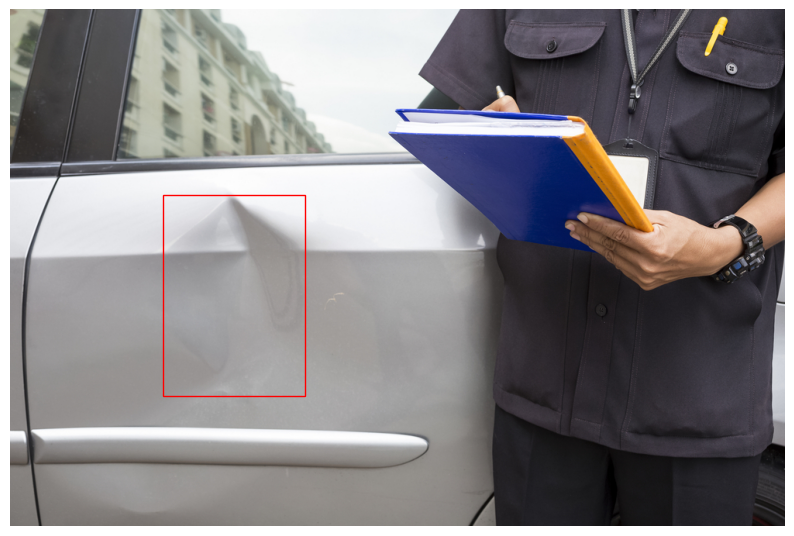

In [6]:
plot_img_pred("/home/bachelor/ml-carbucks/data/car_dd/images/test/002908.jpg", [[
                197.38000000000002,
                239.10982850000002,
                182.66,
                260.079975
            ]], coords="xywh")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6225708].


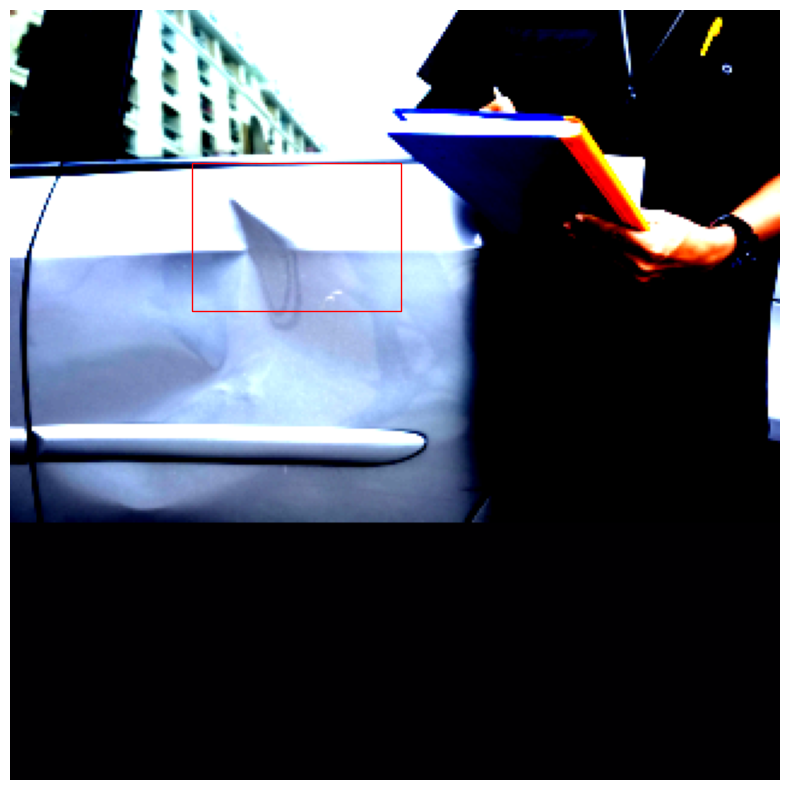

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6225708].


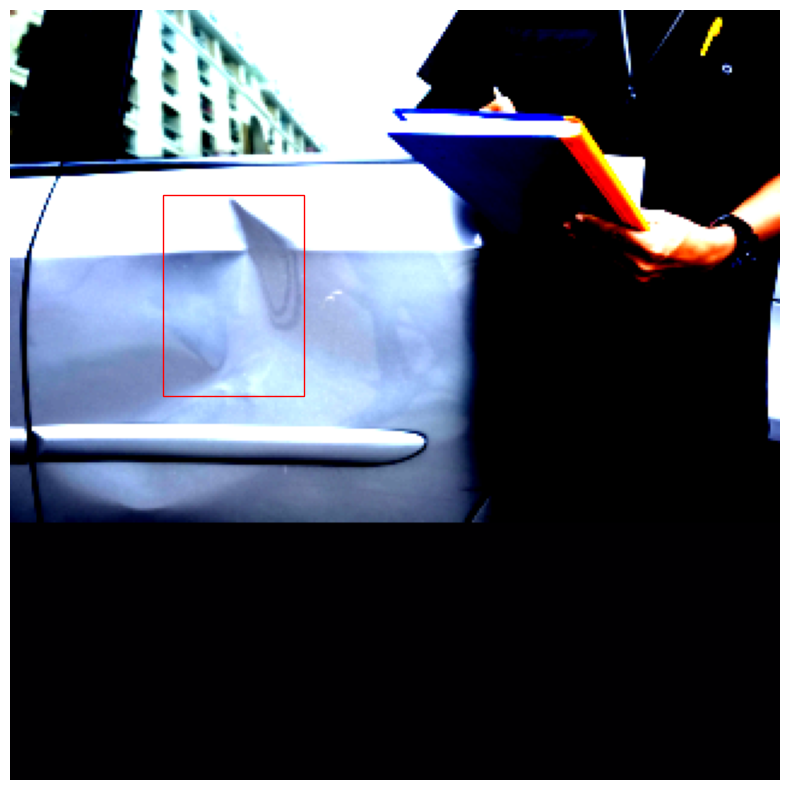

In [8]:
# train_dataset.base_dataset.parser.coco.dataset['annotations']
plot_img_pred(imgs[0].cpu(), boxes[0], coords="xyxy")
plot_img_pred(imgs[0].cpu(), torch.tensor([ [ 76.5151,  63.1616, 159.7407, 121.6128]]), coords="yxyx")
